In [1]:
!rm -rf kdd*

# !wget -q -O ../datasets/kddtrain.gz \
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz

!wget -q -O ../datasets/kddtrain.gz \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

!wget -q -O ../datasets/kddtest.gz \
http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
    
!wget -q -O ../datasets/kddnames \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names

!gunzip ../datasets/kdd*gz

In [2]:
!head -3 ../datasets/kddtrain

0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.


In [3]:
with open('../datasets/kddnames', 'r') as fh:
    header = [line.split(':')[0] 
              for line in fh.read().splitlines()][1:]

header.append('target')

print "Num features:", len(header)-1
print "First 10:", header[:10]

Num features: 41
First 10: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']


In [4]:
train_rdd = sc.textFile('file:///home/vagrant/datasets/kddtrain')
test_rdd = sc.textFile('file:///home/vagrant/datasets/kddtest')

In [5]:
def line_parser(line):

    def piece_parser(piece):
            if "." in piece or piece.isdigit():
                return float(piece)
            else:
                return piece

    return [piece_parser(piece) for piece in line[:-1].split(',')]
              
train_df = sqlContext.createDataFrame(
    train_rdd.map(line_parser), header)

test_df = sqlContext.createDataFrame(
    test_rdd.map(line_parser), header)

In [6]:
print "Train observations:", train_df.count()
print "Test observations:", test_df.count()

Train observations: 494021
Test observations: 311029


In [7]:
train_df.printSchema()

root
 |-- duration: double (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: do

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


cols_categorical = ["protocol_type", "service", "flag","target"]
preproc_stages = []

for col in cols_categorical:
    out_col = col + "_cat"
    preproc_stages.append(
        StringIndexer(
            inputCol=col, outputCol=out_col, handleInvalid="skip"))

pipeline = Pipeline(stages=preproc_stages)
indexer = pipeline.fit(train_df)

train_num_df = indexer.transform(train_df)
test_num_df = indexer.transform(test_df)

In [9]:
print pipeline.getStages()
print
print pipeline
print indexer

[StringIndexer_46ae881ca7febd4a4e81, StringIndexer_49f6bbd151ce1e9bb5a7, StringIndexer_4cfcb173a161bbe6cd60, StringIndexer_4aa581cc25ad8d6eed7e]

Pipeline_450a8f0d2083e96d03ca
PipelineModel_475d9917035781236edb


In [10]:
print "First observation, after the 4 StringIndexers:\n"
print train_num_df.first()

First observation, after the 4 StringIndexers:

Row(duration=0.0, protocol_type=u'tcp', service=u'http', flag=u'SF', src_bytes=181.0, dst_bytes=5450.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=8.0, srv_count=8.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=9.0, dst_host_srv_count=9.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target=u'normal', protocol_type_cat=1.0, service_cat=2.0, flag_cat=0.0, target_cat=2.0)


In [11]:
features_header = set(header) \
                - set(cols_categorical) \
                | set([c + "_cat" for c in cols_categorical]) \
                - set(["target", "target_cat"])
features_header = list(features_header)
print features_header
print "Total numerical features:", len(features_header)

['num_access_files', 'src_bytes', 'srv_count', 'num_outbound_cmds', 'rerror_rate', 'urgent', 'protocol_type_cat', 'dst_host_same_srv_rate', 'duration', 'dst_host_diff_srv_rate', 'srv_serror_rate', 'is_host_login', 'wrong_fragment', 'serror_rate', 'num_compromised', 'is_guest_login', 'dst_host_rerror_rate', 'dst_host_srv_serror_rate', 'hot', 'dst_host_srv_count', 'logged_in', 'srv_rerror_rate', 'dst_host_srv_diff_host_rate', 'srv_diff_host_rate', 'dst_host_same_src_port_rate', 'root_shell', 'service_cat', 'su_attempted', 'dst_host_count', 'num_file_creations', 'flag_cat', 'count', 'land', 'same_srv_rate', 'dst_bytes', 'num_shells', 'dst_host_srv_rerror_rate', 'num_root', 'diff_srv_rate', 'num_failed_logins', 'dst_host_serror_rate']
Total numerical features: 41


In [12]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_header,
    outputCol="features")

Xy_train = (assembler
                .transform(train_num_df)
                .select("features", "target_cat"))
Xy_test = (assembler
                .transform(test_num_df)
                .select("features", "target_cat"))

In [13]:
Xy_train.first()

Row(features=SparseVector(41, {1: 181.0, 2: 8.0, 6: 1.0, 7: 1.0, 19: 9.0, 20: 1.0, 24: 0.11, 26: 2.0, 28: 9.0, 31: 8.0, 33: 1.0, 34: 5450.0}), target_cat=2.0)

In [14]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(
    labelCol="target_cat", featuresCol="features", 
    maxBins=100, seed=101)
fit_clf = clf.fit(Xy_train)

In [15]:
print clf
print fit_clf

RandomForestClassifier_40f9923cb13e74b28cbe
RandomForestClassificationModel (uid=rfc_ac17a1f959a3) with 20 trees


In [16]:
Xy_pred_train = fit_clf.transform(Xy_train)
Xy_pred_test = fit_clf.transform(Xy_test)

In [17]:
print "First observation after classification stage:"
print Xy_pred_test.first()

First observation after classification stage:
Row(features=SparseVector(41, {1: 105.0, 2: 1.0, 6: 2.0, 7: 1.0, 9: 0.01, 19: 254.0, 26: 1.0, 28: 255.0, 31: 1.0, 33: 1.0, 34: 146.0}), target_cat=2.0, rawPrediction=DenseVector([0.0283, 0.0112, 19.3474, 0.0677, 0.0251, 0.1414, 0.0357, 0.1194, 0.1309, 0.041, 0.0257, 0.0079, 0.0046, 0.0004, 0.0029, 0.0016, 0.002, 0.0023, 0.0013, 0.0008, 0.0012, 0.0006, 0.0006]), probability=DenseVector([0.0014, 0.0006, 0.9674, 0.0034, 0.0013, 0.0071, 0.0018, 0.006, 0.0065, 0.002, 0.0013, 0.0004, 0.0002, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0001, 0.0, 0.0]), prediction=2.0)


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="target_cat", predictionCol="prediction", 
    metricName="f1")

print "F1-score train set:", evaluator.evaluate(Xy_pred_train)
print "F1-score test set:", evaluator.evaluate(Xy_pred_test)

F1-score train set: 0.991904372002
F1-score test set: 0.966840043466


In [19]:
# All in one

full_stages = preproc_stages + [assembler, clf]
full_pipeline = Pipeline(stages=full_stages)
full_model = full_pipeline.fit(train_df)
predictions = full_model.transform(test_df)
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.966840043466


In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
def plot_confusion_matrix(cm):
    cm_normalized = \
        cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(
        cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


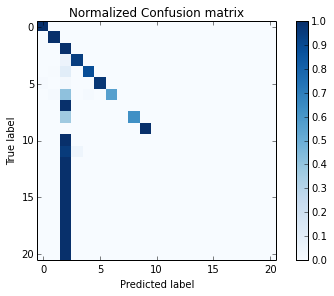

In [21]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(
    predictions.select("prediction", "target_cat").rdd)
conf_matrix = metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

In [22]:
# Let's now improve the score: is the training dataset balanced?

train_composition = train_df.groupBy("target").count().rdd.collectAsMap()
train_composition

{u'back': 2203,
 u'buffer_overflow': 30,
 u'ftp_write': 8,
 u'guess_passwd': 53,
 u'imap': 12,
 u'ipsweep': 1247,
 u'land': 21,
 u'loadmodule': 9,
 u'multihop': 7,
 u'neptune': 107201,
 u'nmap': 231,
 u'normal': 97278,
 u'perl': 3,
 u'phf': 4,
 u'pod': 264,
 u'portsweep': 1040,
 u'rootkit': 10,
 u'satan': 1589,
 u'smurf': 280790,
 u'spy': 2,
 u'teardrop': 979,
 u'warezclient': 1020,
 u'warezmaster': 20}

In [23]:
def set_sample_rate_between_vals(cnt, the_min, the_max):
    if the_min <= cnt <= the_max:
        # no sampling
        return 1
    
    elif cnt < the_min:
        # Oversampling: return many times the same observation
        return the_min/float(cnt)

    else:
        # Subsampling: sometime don't retunt it
        return the_max/float(cnt)
        
sample_rates = {k:set_sample_rate_between_vals(v, 1000, 25000) 
                for k,v in train_composition.iteritems()} 
sample_rates

{u'back': 1,
 u'buffer_overflow': 33.333333333333336,
 u'ftp_write': 125.0,
 u'guess_passwd': 18.867924528301888,
 u'imap': 83.33333333333333,
 u'ipsweep': 1,
 u'land': 47.61904761904762,
 u'loadmodule': 111.11111111111111,
 u'multihop': 142.85714285714286,
 u'neptune': 0.23320677978750198,
 u'nmap': 4.329004329004329,
 u'normal': 0.2569954152017928,
 u'perl': 333.3333333333333,
 u'phf': 250.0,
 u'pod': 3.787878787878788,
 u'portsweep': 1,
 u'rootkit': 100.0,
 u'satan': 1,
 u'smurf': 0.08903450977598917,
 u'spy': 500.0,
 u'teardrop': 1.0214504596527068,
 u'warezclient': 1,
 u'warezmaster': 50.0}

In [24]:
bc_sample_rates = sc.broadcast(sample_rates)

def map_and_sample(el, rates):
    rate = rates.value[el['target']]
    if rate > 1:
        return [el]*int(rate)
    else:
        import random
        return [el] if random.random() < rate else []
            
sampled_train_df = (train_df
                   .flatMap(
                     lambda x: map_and_sample(x, bc_sample_rates))
                   .toDF()
                   .cache())

In [25]:
sampled_train_df.count()

96755

In [26]:
sampled_train_df.first()

Row(duration=0.0, protocol_type=u'tcp', service=u'http', flag=u'SF', src_bytes=181.0, dst_bytes=5450.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=8.0, srv_count=8.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=9.0, dst_host_srv_count=9.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target=u'normal')

In [27]:
full_model = full_pipeline.fit(sampled_train_df)
predictions = full_model.transform(test_df)
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.966865218179


In [28]:
clf = RandomForestClassifier(
    numTrees=50, maxBins=100, seed=101,
    labelCol="target_cat", featuresCol="features")

stages = full_pipeline.getStages()[:-1]
stages.append(clf)

refined_pipeline = Pipeline(stages=stages)

refined_model = refined_pipeline.fit(sampled_train_df)
predictions = refined_model.transform(test_df)
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.967669293816


In [29]:
pipeline_to_clf = Pipeline(
    stages=preproc_stages + [assembler]).fit(sampled_train_df)
train = pipeline_to_clf.transform(sampled_train_df).cache()
test = pipeline_to_clf.transform(test_df)

In [30]:
# May take some 10 minutes

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
    
rf = RandomForestClassifier(
    cacheNodeIds=True, seed=101, labelCol="target_cat", 
    featuresCol="features", maxBins=100)

grid = (ParamGridBuilder() 
        .addGrid(rf.maxDepth, [3, 6, 9, 12]) 
        .addGrid(rf.numTrees, [20, 50]) 
        .build())

cv = CrossValidator(
    estimator=rf, estimatorParamMaps=grid, 
    evaluator=evaluator, numFolds=3)
cvModel = cv.fit(train)

In [31]:
predictions = cvModel.transform(test)
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.969948273422


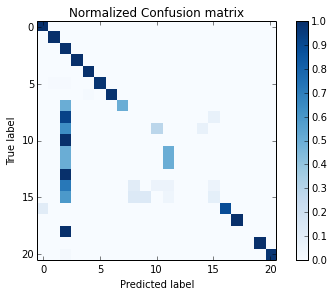

In [32]:
metrics = MulticlassMetrics(predictions.select(
        "prediction", "target_cat").rdd)
conf_matrix = metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

In [33]:
#cleanup
bc_sample_rates.unpersist()
sampled_train_df.unpersist()
train.unpersist()

DataFrame[duration: double, protocol_type: string, service: string, flag: string, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: double, is_host_login: double, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, target: string, 